In [64]:
import os
import numpy as np
import torch
import torch.nn as nn

from model.unet import Unet3D
from model.Diffusion import Diffusion
from model.EMA import ExponentialMovingAverage

from dataset.SimpleShapeDataset.VoxelData import VoxelDataset
from torch.utils.data import Dataset, DataLoader

from utils.visualization import visualize_voxel_map
from diffusers.optimization import get_cosine_schedule_with_warmup

In [49]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [65]:
dataset_dir = "dataset/SimpleShapeDataset/voxel_datasets"

voxel_dataset = VoxelDataset(dataset_dir )

# Create the DataLoader
batch_size = 2
voxel_dataloader = DataLoader(voxel_dataset, batch_size=batch_size, shuffle=True)

In [66]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss(reduction='mean')

    def forward(self, output, target):
        return torch.sqrt(self.mse(output, target))

In [67]:

def main():
    # device = "cpu" if "store_true" else "cuda"
    device = "cuda"
    print(device)
    batch_size = 2; model_ema_steps = 10;num_epochs = 20; model_ema_decay = 0.995

    # Define the model
    model = Diffusion(timesteps=1000,
                           image_size=64,
                           in_channels=1,
                           base_dim=32,
                           dim_mults=[1,2, 4,8]).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=100,
        num_training_steps=(len(voxel_dataloader) * num_epochs),
    )
    adjust = 1* batch_size * model_ema_steps / num_epochs
    alpha = 1.0 - model_ema_decay
    alpha = min(1.0, alpha * adjust)
    model_ema = ExponentialMovingAverage(model, device=device, decay=1.0 - alpha)
# Example usage:
    # loss_fn = RMSELoss()
    loss_fn = nn.MSELoss(reduction='mean')
    min_loss = np.inf
    global_steps = 100000
    
    os.makedirs("results", exist_ok=True)
    checkpoint_path = "results/steps_00100000.pt"

    # if os.path.exists(checkpoint_path):
    #     print("Loading best checkpoint...")
 
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])



    model_ema.load_state_dict(checkpoint["model_ema"])
    for i in range(10):
        model.train()
        for j, image in enumerate(voxel_dataloader):
           
            noise = torch.randn_like(image).to(device)
            image = image.to(device)
            # print("iamge")
            # print(np.mean(image.cpu().numpy()),np.var(image.cpu().numpy()))
            # print("noise")
            # print(np.mean(noise.cpu().numpy()),np.var(noise.cpu().numpy()))
            # Diffusion model forward pass (for 3D ellipsoid data)
            pred = model(image, noise)
            noise = noise.unsqueeze(1)
            loss = loss_fn(pred, noise)
            
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
            if global_steps % 100 == 0:
                print(f"Epoch[{i + 1}/{10}], Step[{j + 1}/{len(voxel_dataloader)}], Loss: {loss.item()}, lr:{lr_scheduler.get_last_lr()[0]}")
            if global_steps% model_ema_steps==0:
                model_ema.update_parameters(model)
            global_steps += 1
            ckpt = {"model": model.state_dict(),
                "model_ema":model_ema.state_dict()}
            if loss < min_loss and i>1:
                min_loss = loss
                print(min_loss)
                torch.save(ckpt, f"results/best.pt")
        # Save model checkpoint
        
        torch.save(ckpt, f"results/steps_{global_steps:08d}.pt")
        
        # Generate samples and save image
        model.eval()
        model_ema.eval()
        samples = model_ema.module.sampling(1, device=device)
        np.save(f"results/steps_{global_steps:06d}.npy", samples.cpu().numpy())
        visualize_voxel_map(samples.cpu().numpy(),visualize=True,save=True,save_dir=f"results/steps_{global_steps:06d}.png")

        
main()

cuda
Epoch[1/10], Step[1/2000], Loss: 0.1947258561849594, lr:2.0000000000000002e-07


KeyboardInterrupt: 

In [9]:
checkpoint_path = "results/best.pt"
device =  "cuda"
if os.path.exists(checkpoint_path):
    print("Loading best checkpoint...")
    model = Diffusion(timesteps=1000,
                           image_size=64,
                           in_channels=1,
                           base_dim=32,
                           dim_mults=[1,2, 4,8]).to(device)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])


    model_ema = ExponentialMovingAverage(model, device=device, decay=1.0 - 0.1)
    model_ema.load_state_dict(checkpoint["model_ema"])
    print("Checkpoint loaded successfully.")
model.eval()

model_ema.eval()
samples = model_ema.module.sampling(1, device=device)


Loading best checkpoint...
Checkpoint loaded successfully.


Sampling: 100%|██████████| 1000/1000 [00:21<00:00, 45.73it/s]


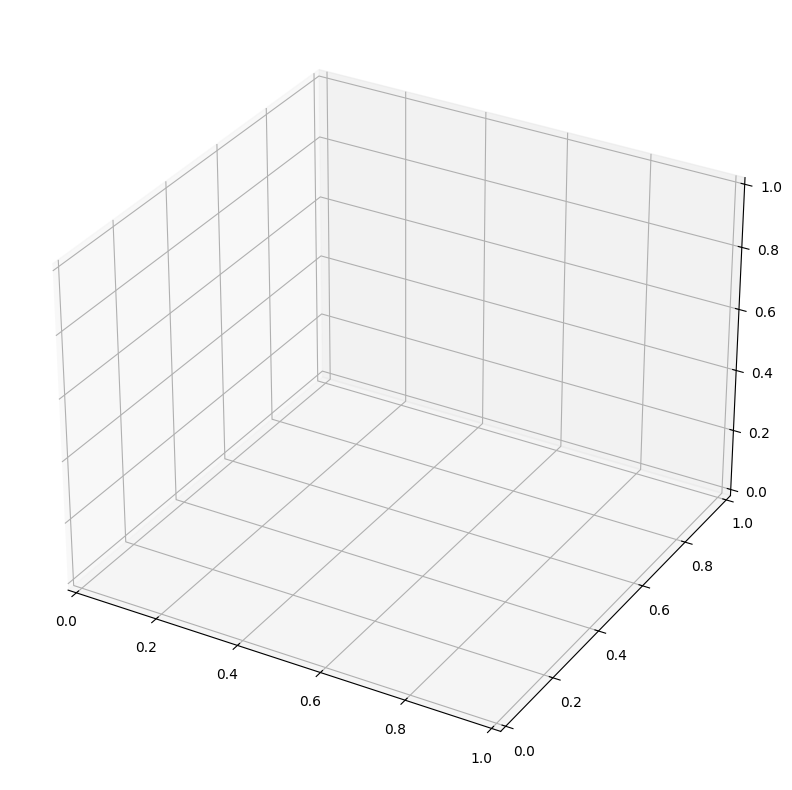

In [10]:
visualize_voxel_map(samples.cpu().numpy(),visualize=False,save=True,save_dir=f"results/steps_.png")

cuda


Sampling: 100%|██████████| 1000/1000 [00:21<00:00, 46.48it/s]


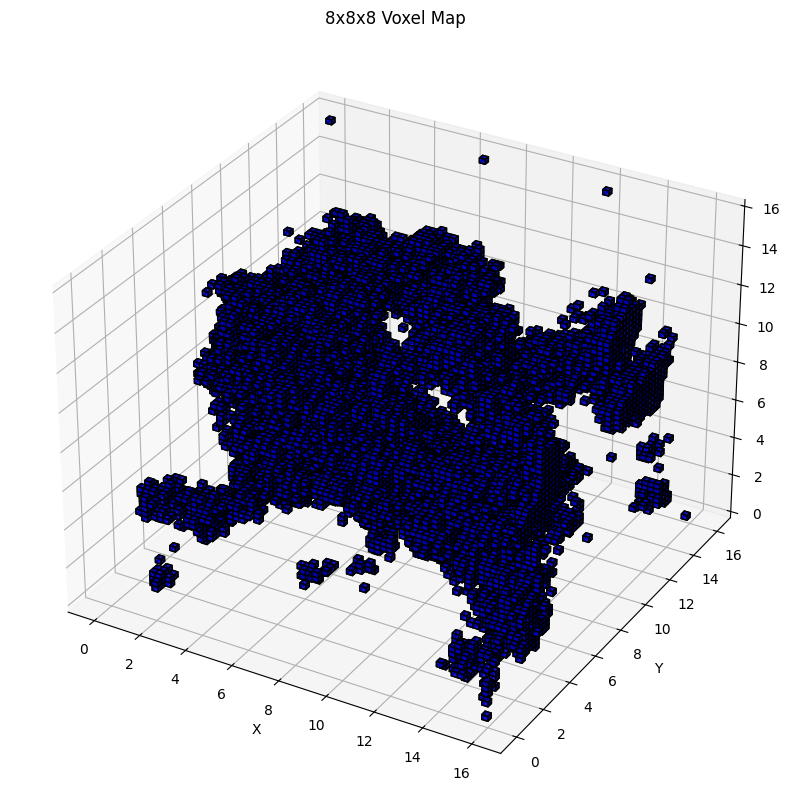

In [63]:
device = "cuda"
print(device)
batch_size = 2; model_ema_steps = 10;num_epochs = 20; model_ema_decay = 0.995

# Define the model
model = Diffusion(timesteps=1000,
                        image_size=64,
                        in_channels=1,
                        base_dim=32,
                        dim_mults=[1,2, 4,8]).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
lr_scheduler = get_cosine_schedule_with_warmup(
optimizer=optimizer,
num_warmup_steps=100,
num_training_steps=(len(voxel_dataloader) * num_epochs),
)
adjust = 1* batch_size * model_ema_steps / num_epochs
alpha = 1.0 - model_ema_decay
alpha = min(1.0, alpha * adjust)
model_ema = ExponentialMovingAverage(model, device=device, decay=1.0 - alpha)
# Example usage:
# loss_fn = RMSELoss()
loss_fn = nn.MSELoss(reduction='mean')
min_loss = np.inf
global_steps = 40000

os.makedirs("results", exist_ok=True)
checkpoint_path = "results/steps_00100000.pt"

# if os.path.exists(checkpoint_path):
#     print("Loading best checkpoint...")

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model'])



model_ema.load_state_dict(checkpoint["model_ema"])
model_ema = ExponentialMovingAverage(model, device=device, decay=1.0 - 0.1)
samples = model_ema.module.sampling(1, device=device)

voxel_1d_array = samples.cpu().numpy()
voxel_1d_array += 1
voxel_1d_array *=0.5
binary_data = (voxel_1d_array > 0.75).astype(int)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# print(binary_data)
# Parameters for voxel map
voxel_size = 0.25
grid_size = 64

# Reshape binary data into 8x8x8 by averaging blocks of 4x4x4
reshaped_data = binary_data.reshape(grid_size, 1,grid_size, 1, grid_size, 1).mean(axis=(1, 3, 5))
voxel_data = (reshaped_data > 0.5).astype(int)  # Convert to binary based on average

# Prepare the 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D grid for the voxel map (dimensions + 1 to align with voxel corners)
x, y, z = np.indices((grid_size + 1, grid_size + 1, grid_size + 1)) * voxel_size

# Display voxels
filled_voxels = (voxel_data == 1)

ax.voxels(x, y, z, filled_voxels, 
        facecolors="blue", edgecolors="black", alpha=0.7)

# Set labels and aspect ratio
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('auto')
plt.title("8x8x8 Voxel Map")

# Show plot
plt.show()

    # plt.savefig(save_dir)

In [16]:
samples

NameError: name 'samples' is not defined